# 1. Labeling tweets sentiment
In this notebook we will tag tweets with K-means algorithm.<br>
The aim is to create target variable, tag the tweets based on the sentiment of the 3 classes positive/neutral/negative.<br>
**There is no guarantee that K-means will group tokens for the sake of sentiment.**<br>
However, we assume that after using word embeddings, tokens with a similar sentiment will not lie too far apart, therefore, due to the lack of a better method, we will use K-means. Please note that the assigned sentiment will not always be correct.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# download and install - Morfeusz 2
!wget http://download.sgjp.pl/morfeusz/20210228/Linux/18.04/64/libmorfeusz2_1.9.17-18.04_amd64.deb
!wget http://download.sgjp.pl/morfeusz/20210228/Linux/18.04/morfeusz2-dictionary-sgjp_20210228_all.deb
!wget http://download.sgjp.pl/morfeusz/20210228/Linux/18.04/64/morfeusz2-1.9.17-cp37-cp37m-linux_x86_64.whl
!sudo dpkg -i libmorfeusz2_1.9.17-18.04_amd64.deb morfeusz2-dictionary-sgjp_20210228_all.deb
!python3 -m pip install morfeusz2-1.9.17-cp37-cp37m-linux_x86_64.whl

--2021-12-30 10:38:29--  http://download.sgjp.pl/morfeusz/20210228/Linux/18.04/64/libmorfeusz2_1.9.17-18.04_amd64.deb
Resolving download.sgjp.pl (download.sgjp.pl)... 193.0.67.154
Connecting to download.sgjp.pl (download.sgjp.pl)|193.0.67.154|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 138532 (135K) [application/x-debian-package]
Saving to: ‘libmorfeusz2_1.9.17-18.04_amd64.deb’

libmorfeusz2_1.9.17 100%[===================>] 135.29K   446KB/s    in 0.3s    

2021-12-30 10:38:29 (446 KB/s) - ‘libmorfeusz2_1.9.17-18.04_amd64.deb’ saved [138532/138532]

--2021-12-30 10:38:29--  http://download.sgjp.pl/morfeusz/20210228/Linux/18.04/morfeusz2-dictionary-sgjp_20210228_all.deb
Resolving download.sgjp.pl (download.sgjp.pl)... 193.0.67.154
Connecting to download.sgjp.pl (download.sgjp.pl)|193.0.67.154|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4716504 (4.5M) [application/x-debian-package]
Saving to: ‘morfeusz2-dictionary-sgjp_20210228_a

In [ ]:
import pandas as pd
import numpy as np

import re
import nltk
import spacy

import morfeusz2
from itertools import groupby

import multiprocessing
from gensim.models.phrases import Phrases, Phraser
from gensim.models import Word2Vec

from sklearn.cluster import KMeans

import matplotlib.pyplot as plt

In [ ]:
morf = morfeusz2.Morfeusz()

In [ ]:
# read tweets data
tweets_data = pd.read_csv('/content/drive/MyDrive/ZUM_NLP/tweets_data.csv', low_memory=False, index_col=0)
tweets_data.columns = ['text']
tweets_data

,text
0,"Kiedy #coronavirus dotrze do Polski, napotka o..."
1,Kolejni Polacy chcą wrócić z Wuhan https://t.c...
2,A tymczasem w Wuhan odcięto od reszty świata o...
3,@PatrykWachowiec @KancelariaSejmu nie zdziwię ...
4,".@MSZ_RP: 19 Polaków chce wrócić z Wuhan, w am..."
...,...
458146,"@Przedszkolanka4 @MagdaCDN W piątek, 21 maja P..."
458147,Przyjdź i porozmawiaj z nami!\n\nDowiedz się w...
458148,Serio chcą wprowadzić pracę zdalną w wymiarze ...
458149,Szczepienia przeciw Covid-19 będą organizowane...


In [ ]:
# Check if there are duplicates. If so, we remove them.
print('Number of duplicates:',tweets_data.duplicated().sum())
print(tweets_data[tweets_data.duplicated(keep=False)].tail())

tweets_data = tweets_data.drop_duplicates()

Number of duplicates: 1234
                                                     text
456197  UEFA postpones Euro 2020 by a year due to coro...
456452  Natychmiastowe globalne użycie iwermektyny zak...
457265  Kwestionariusz przed szczepieniem przeciw COVI...
457596  Natychmiastowe globalne użycie iwermektyny zak...
458073  Kwestionariusz przed szczepieniem przeciw COVI...


In [ ]:
# download stopwords for polish language (find on github)
!wget https://raw.githubusercontent.com/bieli/stopwords/master/polish.stopwords.txt

--2021-12-30 10:38:54--  https://raw.githubusercontent.com/bieli/stopwords/master/polish.stopwords.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2016 (2.0K) [text/plain]
Saving to: ‘polish.stopwords.txt’

polish.stopwords.tx 100%[===================>]   1.97K  --.-KB/s    in 0s      

2021-12-30 10:38:54 (26.2 MB/s) - ‘polish.stopwords.txt’ saved [2016/2016]



In [ ]:
# Read stopwords
with open("polish.stopwords.txt", "r") as f:
    stop_words = [line.rstrip('\n') for line in f]

In [ ]:
# We have to clean and prepare data for further analysis
def lematyzuj(text):
    """
    For each token in a sentence, the function lemmatizes the token if the lemma is unambiguous, if not, it returns the word without lemmatization.
    
        Parameters:
            text (str): A sentence to lematize

        Returns:
            (list): List of tokens after lemmatization
    """
    sentence = morf.analyse(text)
    tokens = [(x[0],x[2][0]) for x in sentence]
    tokens = list(dict.fromkeys(tokens))
    sentence = [(x[0],x[2][1]) for x in sentence]
    sentence = list(dict.fromkeys(sentence))
    res = [list(v) for i, v in groupby(sentence, lambda x: x[0])]
    token_counts = [len(x) for x in res]
    return [res[i][0][1].split(':', 1)[0] if token_counts[i]==1 else tokens[i][1] for i in range(len(token_counts))]


def clean_text(text):
    """
    Clean text from url, twitter usernames, digits, stop_words. Also lematize sentences if possible.

        Parameters:
            text (str): A sentence to preprocess

        Returns:
            text (list): List of tokens after cleaned and lematization
    """
    text = str(text).lower()
    text = re.sub('https?:\/\/[a-zA-Z0-9@:%._\/+~#=?&;-]*', ' ', text)
    text = re.sub('\$[a-zA-Z0-9]*', ' ', text)
    text = re.sub('\@[a-zA-Z0-9]*', ' ', text)
    text = re.sub('\d+', ' ', text)
    text = re.sub(r'[^\w]', ' ', text)
    text = re.sub('\t', '', text)
    text = ' '.join([w for w in text.split() if ((len(w)>1) and (w not in stop_words))])
    text = lematyzuj(text)
    return text 

In [ ]:
# Example of cleaning text
print(tweets_data['text'][2])
clean_text(tweets_data['text'][2])

A tymczasem w Wuhan odcięto od reszty świata obszar porównywalny do Syrii.  MCD i Starbucks zawiesili działalność i… https://t.co/YWWQPKSMJV


['tymczasem',
 'Wuhan',
 'odciąć',
 'reszta',
 'świat',
 'obszar',
 'porównywalny',
 'Syria',
 'MCD',
 'starbucks',
 'zawiesić',
 'działalność']

In [ ]:
tweets_data['cleaned_text'] = tweets_data['text'].apply(clean_text)
tweets_data

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,text,cleaned_text
0,"Kiedy #coronavirus dotrze do Polski, napotka o...","[coronavirus, dotrzeć, polski, napotkać, opór,..."
1,Kolejni Polacy chcą wrócić z Wuhan https://t.c...,"[kolejny, Polak, chcieć, wrócić, Wuhan]"
2,A tymczasem w Wuhan odcięto od reszty świata o...,"[tymczasem, Wuhan, odciąć, reszta, świat, obsz..."
3,@PatrykWachowiec @KancelariaSejmu nie zdziwię ...,"[zdziwić, powiedzieć, listy, pojechać, china, ..."
4,".@MSZ_RP: 19 Polaków chce wrócić z Wuhan, w am...","[_rp, polak, chcieć, wrócić, Wuhan, ambasada, ..."
...,...,...
458146,"@Przedszkolanka4 @MagdaCDN W piątek, 21 maja P...","[piątek, maja, punkt, szczepień, powszechny, u..."
458147,Przyjdź i porozmawiaj z nami!\n\nDowiedz się w...,"[przyjść, porozmawiać, dowiedzieć, szczepieniu..."
458148,Serio chcą wprowadzić pracę zdalną w wymiarze ...,"[serio, chcieć, wprowadzić, praca, zdalny, wym..."
458149,Szczepienia przeciw Covid-19 będą organizowane...,"[szczepienia, przeciw, covid, organizować, szk..."


In [ ]:
# Detection of common phrases - multi-word expressions, word n-gram collocations

sent = [row for row in tweets_data['cleaned_text']]

phrases = Phrases(sent, min_count=1, progress_per=50000)
bigram = Phraser(phrases)
sentences = bigram[sent]
del sent

for i in range(6):
    print(sentences[i])

['coronavirus', 'dotrzeć_polski', 'napotkać_opór', 'znakomicie', 'zorganizować', 'publiczny', 'system_ochrona', 'zdrowie', 'napotkać']
['kolejny', 'Polak', 'chcieć_wrócić', 'Wuhan']
['tymczasem', 'Wuhan', 'odciąć', 'reszta_świat', 'obszar', 'porównywalny', 'Syria', 'MCD', 'starbucks', 'zawiesić_działalność']
['zdziwić', 'powiedzieć', 'listy', 'pojechać', 'china', 'Wuhan', 'odważny', 'pojechać']
['_rp', 'polak', 'chcieć_wrócić', 'Wuhan', 'ambasada_RP', 'pekin', 'powołać', 'sztab_kryzysowy', 'spotkanie']
['cykl', 'grano', 'przypadku', 'Wuhan', 'ciekawy', 'słowo', 'szczególnie', 'wziąć_uwaga', 'doświadczen']


In [ ]:
#  Word2Vec model initialization
w2v_model = Word2Vec(min_count=5,
                     window=5,
                     size=300,
                     sample=1e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     seed=24,
                     workers=multiprocessing.cpu_count()-1)

w2v_model.build_vocab(sentences, progress_per=50000)

In [ ]:
# Train Word2Vec model
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

(35739293, 88219950)

In [ ]:
w2v_model.wv.most_similar(positive=["zło"])

[('liberał', 0.9051406979560852),
 ('lewactwo', 0.8907325267791748),
 ('komuszy', 0.8804754614830017),
 ('faszyzm', 0.8776344060897827),
 ('totalitaryzm', 0.8764626979827881),
 ('neo', 0.8706972599029541),
 ('katolicyzm', 0.8669523000717163),
 ('komuch', 0.8637688755989075),
 ('zdradziecki', 0.8636662364006042),
 ('zbrodnie', 0.8618335127830505)]

In [ ]:
w2v_model.wv.most_similar(positive=["zwyczajny"])

[('zgadzać_pan', 0.9150629043579102),
 ('_gajcy', 0.9107824563980103),
 ('zdegenerować', 0.910279393196106),
 ('histeryczny', 0.9070878624916077),
 ('patologiczny', 0.9053324460983276),
 ('wolnościowiec', 0.9038804173469543),
 ('irytować', 0.9027847051620483),
 ('ślepa', 0.901770830154419),
 ('sekcie', 0.9011987447738647),
 ('przyzwoitość', 0.9007264971733093)]

In [ ]:
w2v_model.wv.most_similar(positive=["dobrze"])

[('spokojnie', 0.8256214261054993),
 ('git', 0.8214492797851562),
 ('fajnie', 0.815838098526001),
 ('chyba', 0.8135422468185425),
 ('postraszyć', 0.8134819269180298),
 ('alba', 0.8126699924468994),
 ('powalić', 0.8103116750717163),
 ('kowidowe', 0.8093189001083374),
 ('ciut', 0.8089665770530701),
 ('drugą_strona', 0.80877286195755)]

In [ ]:
w2v_model.save("/content/drive/MyDrive/ZUM_NLP/word2vec_model/word2vec.model")

In [ ]:
word_vectors = w2v_model.wv

In [ ]:
# Group tokens with K-menas - 3 clusters
model = KMeans(n_clusters=3, max_iter=1000, random_state=42, n_init=50).fit(X=word_vectors.vectors.astype('double'))

In [ ]:
# list of 30 tokens 'most similar' (cosine similarity) to cluster_1
word_vectors.similar_by_vector(model.cluster_centers_[1], topn=30, restrict_vocab=None)

[('mumu', 0.9947563409805298),
 ('zam_zam', 0.9940850734710693),
 ('seriously', 0.9940599203109741),
 ('congratulations', 0.9940536618232727),
 ('blame', 0.9934186935424805),
 ('macać_nak', 0.9932833909988403),
 ('bbnaijalockdown', 0.9930076599121094),
 ('salute', 0.9927537441253662),
 ('biko', 0.9926707744598389),
 ('flip', 0.9925658702850342),
 ('corona_ka', 0.9924889802932739),
 ('funeral', 0.9923903942108154),
 ('aunty', 0.9922366738319397),
 ('barawo', 0.9919962286949158),
 ('opomulero', 0.9919708967208862),
 ('yhooo', 0.9918853044509888),
 ('artwork', 0.9918769001960754),
 ('Nast_Nast', 0.9918615221977234),
 ('training', 0.991744339466095),
 ('Marr', 0.9916349649429321),
 ('nysc', 0.991405725479126),
 ('vex', 0.9914037585258484),
 ('nowadays', 0.9913655519485474),
 ('coronavirus_impact', 0.9911034107208252),
 ('wife', 0.9908180832862854),
 ('cory', 0.9908180236816406),
 ('coward', 0.9907286167144775),
 ('minutes', 0.9907249212265015),
 ('twirinde', 0.9906986951828003),
 ('adiós',

In [ ]:
def cosine_similarity(word):
    """
    Function returns tuple with cosine_similarity between word and each cluster center in order (0,1,2).
    """
    return (np.dot(w2v_model.wv[word], model.cluster_centers_[0])/(np.linalg.norm(w2v_model.wv[word])* np.linalg.norm(model.cluster_centers_[0])),
            np.dot(w2v_model.wv[word], model.cluster_centers_[1])/(np.linalg.norm(w2v_model.wv[word])* np.linalg.norm(model.cluster_centers_[1])),
            np.dot(w2v_model.wv[word], model.cluster_centers_[2])/(np.linalg.norm(w2v_model.wv[word])* np.linalg.norm(model.cluster_centers_[2])),
            )


print('dobrze:',cosine_similarity('dobrze'))
print('dobro:',cosine_similarity('dobro'))

print('zwyczajnie:',cosine_similarity('zwyczajnie'))

print('źle:',cosine_similarity('źle'))
print('fatalnie:',cosine_similarity('fatalnie'))

dobrze: (0.7278174554580622, 0.23872804260567815, 0.4702140888109769)
dobro: (0.7354344931677431, 0.31770696527559167, 0.4171671001480103)
zwyczajnie: (0.7875447157584342, 0.22754394516385887, 0.41943219293071793)
źle: (0.6048821261638148, 0.17303315695567506, 0.4890198766023884)
fatalnie: (0.7332027169451772, 0.2927533636592969, 0.6731142756460755)


In [ ]:
# Name clusters based on the sentiment
# **this step may not be perfect**
positive_cluster_center = model.cluster_centers_[2]
negative_cluster_center = model.cluster_centers_[0]
neutral_cluster_center= model.cluster_centers_[1]

In [ ]:
def similarity_to_claster_center(word):
    """
    Function returns cosine_similarity between word and nearest cluster center.
    """
    return max([np.dot(w2v_model.wv[word], model.cluster_centers_[0])/(np.linalg.norm(w2v_model.wv[word])* np.linalg.norm(model.cluster_centers_[0])),
            np.dot(w2v_model.wv[word], model.cluster_centers_[1])/(np.linalg.norm(w2v_model.wv[word])* np.linalg.norm(model.cluster_centers_[1])),
            np.dot(w2v_model.wv[word], model.cluster_centers_[2])/(np.linalg.norm(w2v_model.wv[word])* np.linalg.norm(model.cluster_centers_[2])),
    ])

In [ ]:
# to each word form dictionary assing cluster (sentiment)
words = pd.DataFrame(word_vectors.index2entity)
words.columns = ['words']
words['vectors'] = words.words.apply(lambda x: word_vectors[f'{x}'])
words['cluster'] = words.vectors.apply(lambda x: model.predict([np.array(x)]))
words.cluster = words.cluster.apply(lambda x: x[0])
words['cluster_value'] = [-1 if i==2 else 1 if i==0 else 0 for i in words.cluster]
words['closeness_score'] = words['words'].apply(similarity_to_claster_center)

words

,words,vectors,cluster,cluster_value,closeness_score
0,covid,"[0.023781369, -0.23404439, -0.20149498, -0.682...",2,-1,0.410105
1,koronawirus,"[0.20906301, 0.42998946, -0.122425266, -0.6364...",2,-1,0.413584
2,być,"[-0.25619674, -0.026158268, -0.25341624, -0.11...",0,1,0.423526
3,osoba,"[0.3147368, -0.0018857152, 0.20254618, -0.1688...",2,-1,0.476418
4,szczepionka,"[-0.04895228, 0.12774213, -0.32942268, -0.5328...",0,1,0.380196
...,...,...,...,...,...
54813,człowiek_wzbogacić,"[0.08564358, -0.055626485, 0.017842641, -0.066...",2,-1,0.915105
54814,mobilny_mojeikp,"[0.22619818, 0.033759657, 0.08503392, -0.05026...",2,-1,0.819594
54815,UE_jedyni,"[0.03669548, -0.05378476, 0.11215979, -0.08447...",2,-1,0.848032
54816,absolutnie_stanowić,"[0.16009146, -0.06991461, 0.12108356, -0.11980...",0,1,0.790847


In [ ]:
# take a look on NEGATIVE cluster
words[words["cluster_value"]==-1].sort_values("closeness_score", ascending=False)

,words,vectors,cluster,cluster_value,closeness_score
54233,wakcynacja,"[0.09994153, -0.07831802, 0.015222394, -0.0118...",2,-1,0.979797
51664,zaledwie_proca,"[0.09091048, -0.06649234, 0.046070047, -0.0223...",2,-1,0.979320
45703,śledzić_rozprzestrzeniać,"[0.08924603, -0.037790496, 0.07606396, -0.0277...",2,-1,0.978318
41220,francj,"[0.10519217, -0.01738228, 0.047605272, -0.0117...",2,-1,0.972604
51288,stabilizować_sytuacja,"[0.097355075, -0.011333231, 0.0614646, -0.0448...",2,-1,0.972287
...,...,...,...,...,...
43,Wuhan,"[0.20881653, 0.48727962, 0.82785666, 0.2413991...",2,-1,0.296372
3029,zapraszać_lektura,"[0.35565928, 0.2683104, -0.33374465, 0.2786195...",2,-1,0.292223
8,polski,"[-0.36213943, 0.46713957, 0.519176, 0.0792813,...",2,-1,0.288161
766,gt_gt,"[0.32757905, -0.2301268, 1.1706201, -0.9393183...",2,-1,0.266239


In [ ]:
# take a look on NEUTRAL cluster
words[words["cluster_value"]==0].sort_values("closeness_score", ascending=False)

,words,vectors,cluster,cluster_value,closeness_score
42067,mumu,"[0.12470197, -0.0558787, 0.018435266, 0.004465...",1,0,0.994756
46078,zam_zam,"[0.10593176, -0.08867446, 0.009946729, -0.0082...",1,0,0.994085
35794,seriously,"[0.09732636, -0.04903028, 0.0027432546, -0.000...",1,0,0.994060
32938,congratulations,"[0.09217092, -0.06691345, 0.005208971, -0.0219...",1,0,0.994054
32519,blame,"[0.10875139, -0.070119396, 0.020498034, -0.015...",1,0,0.993419
...,...,...,...,...,...
1613,PCR,"[0.55351824, 0.15746982, -0.1668772, -0.070102...",1,0,0.348576
549,news,"[0.20725365, -0.4728116, -0.9511515, 0.1918754...",1,0,0.334151
2404,dr_Księga_Habakuka,"[0.6462533, -0.47974467, 0.122198366, -0.36395...",1,0,0.329494
6418,coca_cola,"[0.01885249, -0.23205206, 0.7199377, -0.764062...",1,0,0.302276


In [ ]:
# take a look on POSITIVE cluster
words[words["cluster_value"]==1].sort_values("closeness_score", ascending=False)

,words,vectors,cluster,cluster_value,closeness_score
40981,zbój,"[-0.01845619, -0.13889033, 0.009665984, -0.082...",0,1,0.990157
31864,wolak,"[0.023065409, -0.1347933, 0.011821806, -0.0693...",0,1,0.989621
39316,_na_x,"[0.034178372, -0.102068685, 0.014716815, -0.07...",0,1,0.988849
26434,słów_brak,"[0.049831167, -0.09528946, 0.0035918364, -0.06...",0,1,0.988391
52310,szary_obywatel,"[0.032674097, -0.086410955, 0.005394015, -0.06...",0,1,0.988186
...,...,...,...,...,...
53978,uwiwuw,"[0.0016162613, 0.00012503528, 0.001438982, 0.0...",0,1,-0.074057
50753,lolno,"[-0.0012566888, -0.0009039694, -0.0011464409, ...",0,1,-0.077092
47052,awume_wena,"[0.0011733267, -0.001405678, 0.0011855921, 0.0...",0,1,-0.088851
40680,ywna,"[-0.0010918299, 0.0012676442, -0.0014625844, 0...",0,1,-0.095377


In [ ]:
# we can manually assign some words to the right cluster
positive = ['dobrze','dobro','super','ekstra','wesoły','świetnie','cudownie','miło','uroczo','słodko']
neutral = ['zwyczajnie','neutralny','normalny','typowo','przeciętnie','powszechnie','standardowy','zwykły']
negative= ['głupi','głupek','źle','zło','fatalnie','strasznie','niedobrze','tragedia']
for i in positive:
    words.loc[words["words"]==i,"cluster_value"] = 1
    
for i in neutral:
    words.loc[words["words"]==i,"cluster_value"] = 0
    
for i in negative:
    words.loc[words["words"]==i,"cluster_value"] = -1


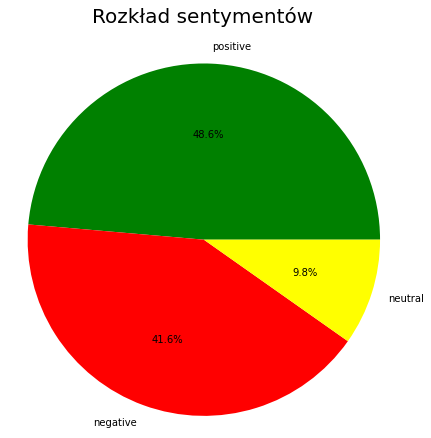

,index,sentiments
0,positive,26653
1,negative,22808
2,neutral,5357


In [ ]:
# what is the sentiment distribution on words
emotion = {0: "neutral",
           1: "positive",
          -1: "negative"}

words["sentiments"] = words["cluster_value"].map(emotion)

fig = plt.gcf()
fig.set_size_inches(7,7)
colors = ["green","red","yellow"]
df_pie=words["sentiments"].value_counts().reset_index()
plt.pie(df_pie["sentiments"], labels = df_pie["index"], radius=2, colors=colors, autopct="%1.1f%%")
plt.axis('equal')
plt.title("Rozkład sentymentów\n", fontsize=20)
plt.show()
df_pie

In [ ]:
# asign sentiment to each tweet - average sentiment of words in tweet
def get_sentiments(x, sent_dict):
    total = 0
    count = 0
    test = x["cleaned_text"]
    for t in test:
        if words_dict.get(t):
            total += int(sent_dict.get(t))
        count+=1
    avg = total/(count if count != 0 else 1)
    sentiment = -1 if avg < -0.15 else 1 if avg > 0.15 else 0
    return sentiment

In [ ]:
words_dict = dict(zip(words.words, words.cluster_value))

In [ ]:
tweets_data["sentiment"] = tweets_data.apply(get_sentiments, args=(words_dict,), axis=1)

tweets_data.to_csv('/content/drive/MyDrive/ZUM_NLP/tweets_data_labeled.csv')

tweets_data

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,text,cleaned_text,sentiment,sentiments_val
0,"Kiedy #coronavirus dotrze do Polski, napotka o...","[coronavirus, dotrzeć, polski, napotkać, opór,...",0,neutral
1,Kolejni Polacy chcą wrócić z Wuhan https://t.c...,"[kolejny, Polak, chcieć, wrócić, Wuhan]",1,positive
2,A tymczasem w Wuhan odcięto od reszty świata o...,"[tymczasem, Wuhan, odciąć, reszta, świat, obsz...",-1,negative
3,@PatrykWachowiec @KancelariaSejmu nie zdziwię ...,"[zdziwić, powiedzieć, listy, pojechać, china, ...",1,positive
4,".@MSZ_RP: 19 Polaków chce wrócić z Wuhan, w am...","[_rp, polak, chcieć, wrócić, Wuhan, ambasada, ...",1,positive
...,...,...,...,...
458146,"@Przedszkolanka4 @MagdaCDN W piątek, 21 maja P...","[piątek, maja, punkt, szczepień, powszechny, u...",-1,negative
458147,Przyjdź i porozmawiaj z nami!\n\nDowiedz się w...,"[przyjść, porozmawiać, dowiedzieć, szczepieniu...",0,neutral
458148,Serio chcą wprowadzić pracę zdalną w wymiarze ...,"[serio, chcieć, wprowadzić, praca, zdalny, wym...",0,neutral
458149,Szczepienia przeciw Covid-19 będą organizowane...,"[szczepienia, przeciw, covid, organizować, szk...",-1,negative


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


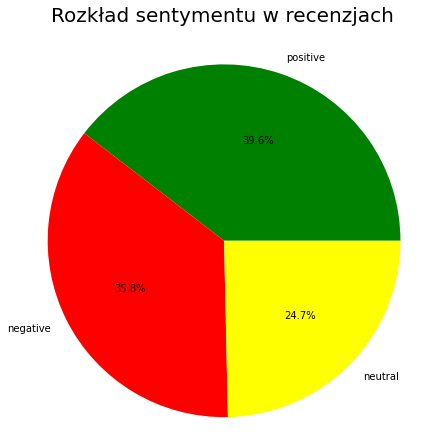

,index,sentiments_val
0,positive,180767
1,negative,163505
2,neutral,112646


In [ ]:
# what is the sentiment distribution on tweets
emotion = {0: "neutral",
           1: "positive",
          -1: "negative"}

tweets_data["sentiments_val"] = tweets_data["sentiment"].map(emotion)
df_pie = tweets_data["sentiments_val"].value_counts().reset_index()
fig = plt.gcf()
fig.set_size_inches(7,7)
colors = ["green","red","yellow"]
plt.pie(df_pie["sentiments_val"],labels= df_pie["index"],radius=2,autopct="%1.1f%%", colors=colors)
plt.axis('equal')
plt.title("Rozkład sentymentu w recenzjach\n", fontsize=20)
plt.show()
df_pie